<a href="https://colab.research.google.com/github/mvolle/bmis331final/blob/main/BMISProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install requests pandas matplotlib --quiet

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:

# Your API key
API_KEY = 'rrS8uEWJO8jivZI0fjzAyIJaSnoc2CYF'

def get_price_data(ticker, from_date, to_date, timespan='day', limit=5000):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{from_date}/{to_date}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': limit,
        'apiKey': API_KEY
    }

    res = requests.get(url, params=params)
    data = res.json()

    if 'results' not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame(data['results'])
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    df.rename(columns={
        't': 'date', 'o': 'open', 'h': 'high', 'l': 'low',
        'c': 'close', 'v': 'volume'
    }, inplace=True)
    return df


In [ ]:
df = get_price_data('NVDA', '2023-01-01', '2024-01-01')
df.head()

,volume,vw,open,close,high,low,date,n
0,361025740.0,26.6546,26.837,26.531,27.0000,26.365,2023-03-27 04:00:00,407677
1,356103780.0,26.1762,26.447,26.410,26.5130,25.850,2023-03-28 04:00:00,411937
2,393693870.0,26.8994,26.825,26.984,27.0780,26.597,2023-03-29 04:00:00,451117
3,364515740.0,27.3291,27.229,27.383,27.4990,27.102,2023-03-30 04:00:00,441761
4,433932770.0,27.5789,27.140,27.777,27.8343,27.105,2023-03-31 04:00:00,496292


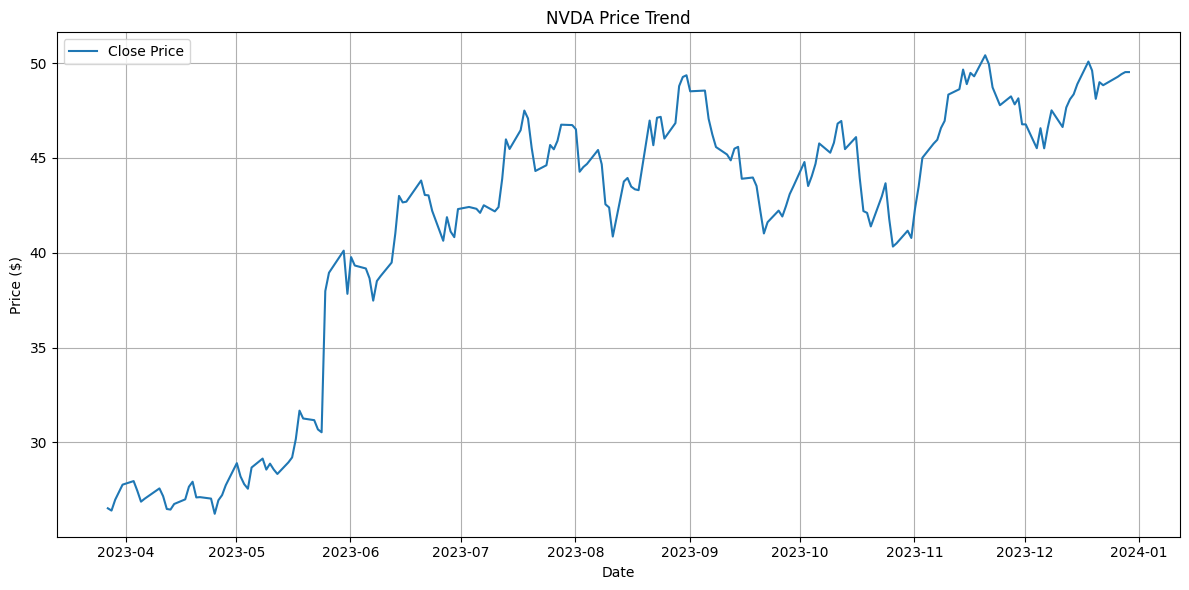

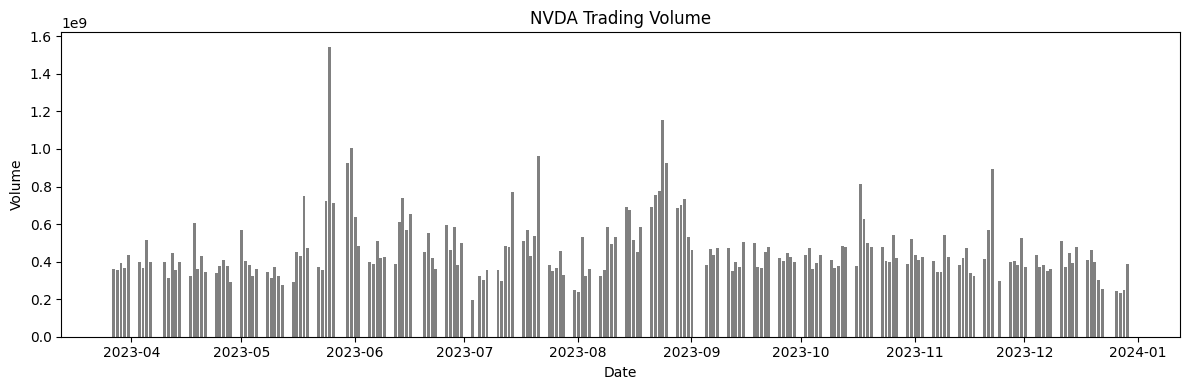

In [ ]:
# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title("NVDA Price Trend")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot volume
plt.figure(figsize=(12, 4))
plt.bar(df['date'], df['volume'], color='gray')
plt.title("NVDA Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()


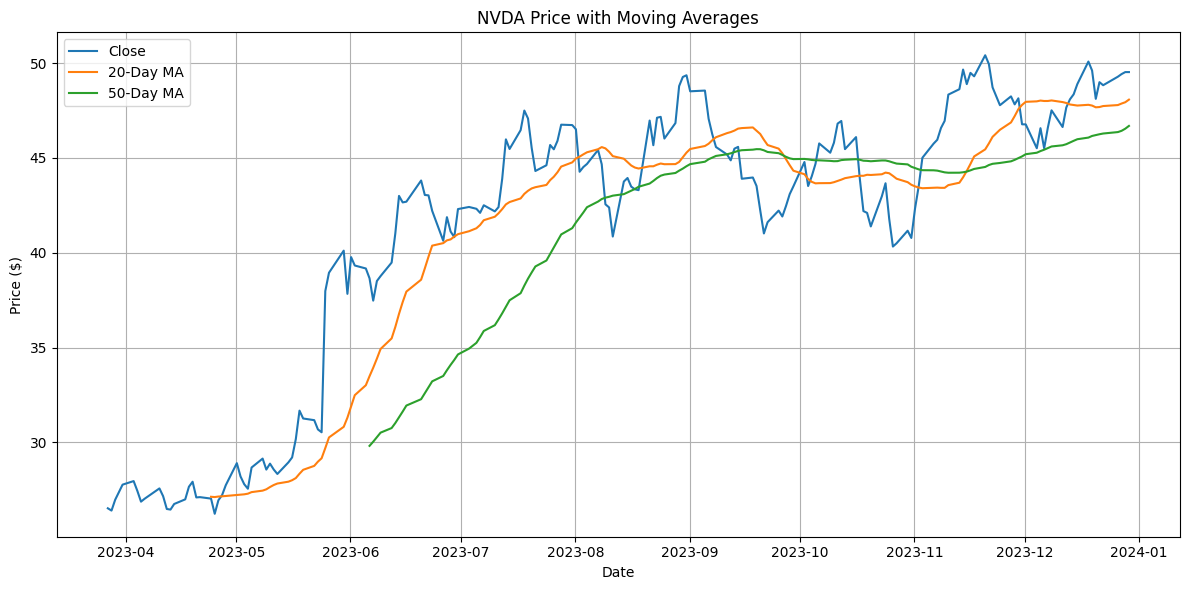

In [ ]:
df['ma_20'] = df['close'].rolling(20).mean()
df['ma_50'] = df['close'].rolling(50).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Close')
plt.plot(df['date'], df['ma_20'], label='20-Day MA')
plt.plot(df['date'], df['ma_50'], label='50-Day MA')
plt.title("NVDA Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
def screen_price_movement(tickers, days_back=5):
    today = datetime.today().date()
    from_date = (today - pd.Timedelta(days=days_back + 3)).isoformat()  # buffer for weekends
    to_date = today.isoformat()

    results = []

    for ticker in tickers:
        try:
            df = get_price_data(ticker, from_date, to_date)
            if df.empty or len(df) < days_back:
                continue

            # Take last 'days_back' rows
            df = df.tail(days_back)
            start_price = df['close'].iloc[0]
            end_price = df['close'].iloc[-1]
            change = ((end_price - start_price) / start_price) * 100

            results.append({
                'Ticker': ticker,
                'Start Price': round(start_price, 2),
                'End Price': round(end_price, 2),
                'Change (%)': round(change, 2)
            })
        except Exception as e:
            print(f"Error loading {ticker}: {e}")

    return pd.DataFrame(results).sort_values('Change (%)', ascending=False)


In [4]:
# Define your watchlist
my_watchlist = ['AAPL', 'MSFT', 'TSLA', 'NVDA', 'AMZN', 'META', 'GOOGL', 'AMD']

# Run the screener
screener_df = screen_price_movement(my_watchlist, days_back=5)
screener_df


Error: {'status': 'ERROR', 'request_id': '225029b2a12ce23869cf73e11f44300a', 'error': "You've exceeded the maximum requests per minute, please wait or upgrade your subscription to continue. https://polygon.io/pricing"}
Error loading META: 'NoneType' object has no attribute 'empty'
Error: {'status': 'ERROR', 'request_id': '53d71cb4d1436990e987783a8d51373a', 'error': "You've exceeded the maximum requests per minute, please wait or upgrade your subscription to continue. https://polygon.io/pricing"}
Error loading GOOGL: 'NoneType' object has no attribute 'empty'
Error: {'status': 'ERROR', 'request_id': '65c8a2a145e20707587d8955fe099b82', 'error': "You've exceeded the maximum requests per minute, please wait or upgrade your subscription to continue. https://polygon.io/pricing"}
Error loading AMD: 'NoneType' object has no attribute 'empty'


,Ticker,Start Price,End Price,Change (%)
0,AAPL,220.73,217.90,-1.28
1,MSFT,393.08,378.80,-3.63
4,AMZN,203.26,192.72,-5.19
2,TSLA,278.39,263.55,-5.33
3,NVDA,121.41,109.67,-9.67


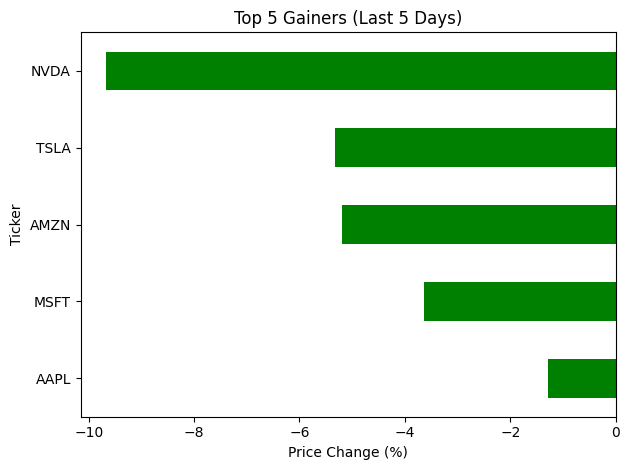

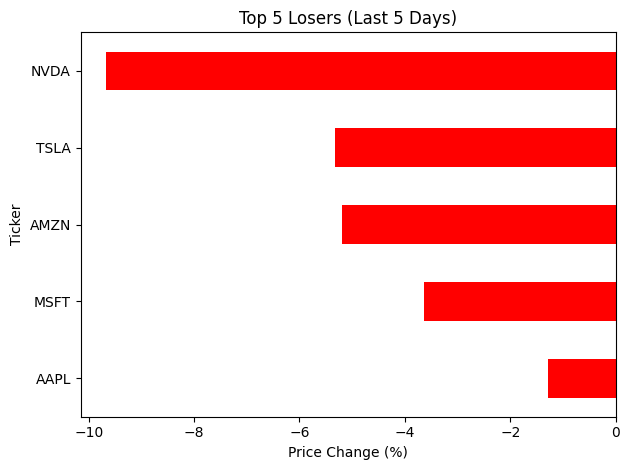

In [5]:
top_movers = screener_df.head(5).set_index('Ticker')
top_movers['Change (%)'].plot(kind='barh', color='green', title='Top 5 Gainers (Last 5 Days)')
plt.xlabel('Price Change (%)')
plt.tight_layout()
plt.show()

bottom_movers = screener_df.tail(5).set_index('Ticker')
bottom_movers['Change (%)'].plot(kind='barh', color='red', title='Top 5 Losers (Last 5 Days)')
plt.xlabel('Price Change (%)')
plt.tight_layout()
plt.show()
